## Getting the Data

Citibike data is provided as `zip` files containing `csv` files organized by trip start time. For the purposes of visualization we need to download a month's sample of CitiBike trips, unpack it, load the `csv` into a `pandas` `DataFrame`, reslice the data by bike-week, draw samples from this resliced data, and save the results.

In [14]:
import numpy as np
import pandas as pd
import requests
import zipfile
import io
from datetime import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Download a month's sample of CitiBike trips, unpack it into a `csv`, and load it into a `pandas` `DataFrame`.

In [2]:
r = requests.get('https://s3.amazonaws.com/tripdata/201603-citibike-tripdata.zip')
with zipfile.ZipFile(io.BytesIO(r.content)) as ar:
    trip_data = pd.read_csv(ar.open('201603-citibike-tripdata.csv'))

In [3]:
trip_data.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72,W 52 St & 11 Ave,40.767272,-73.993929,427,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72,W 52 St & 11 Ave,40.767272,-73.993929,254,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72,W 52 St & 11 Ave,40.767272,-73.993929,493,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72,W 52 St & 11 Ave,40.767272,-73.993929,478,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72,W 52 St & 11 Ave,40.767272,-73.993929,151,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1


Sense check: how many bicycles are in the system?

In [4]:
len(trip_data['bikeid'].unique())

7484

Sense check: how many stations are in the system?

In [5]:
len(trip_data['start station name'].unique())

473

Everything seems tidy.

## Data Format and Shaping

A few non-obvious things about the data:

* `tripduration` is an exact count in seconds.
* `usertype` is either subscriber or customer.
* `gender` is 1 for male, 2 for female, and 0 for unknown. Gender is 0 when the rider is a customer, who do not provide their gender.
* `gender` [skews heavily male](http://www.nytimes.com/2015/07/08/nyregion/a-mission-for-citi-bike-recruiting-more-female-cyclists.html?_r=0).
* `birth year` is an empty space (`" "`) in the raw dataset when the user is a customer, which `pandas` interprets as an `np.nan` value.
* CitiBike ridership is [heavily seasonal](http://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/) (this post is worth reading for anyone at all interested in the subject), with bikes recieving four times as many rides per day at their peak (in the early fall) as in their trough (deep winter).

We need to covert those `starttime` and `stoptime` objects into `np.datetime64` objects.

In [6]:
trip_data['starttime'] = trip_data['starttime'].map(lambda x: np.datetime64(datetime.strptime(x, "%m/%d/%Y %H:%M:%S")))
trip_data['stoptime'] = trip_data['stoptime'].map(lambda x: np.datetime64(datetime.strptime(x, "%m/%d/%Y %H:%M:%S")))

## Sampling Bike-Weeks

Now let's take a sample of 100 random CitiBike-weeks. We'll randomly pick 10 bikes on the week starting on Saturday, March 6th.

CitiBike ridership is heavily dependent on the day of the week, the time of day, and, to a lesser extent, on the weather. This one specific week was chosen because it was one of good weather (unusually hot, even) which ought to be representative of the greater whole of ridership days in the city.

We could easily extend this to selecting a random week starting on Saturday from throughout the year.

In [7]:
random_bikes = random.sample(list(trip_data['bikeid'].unique()), 10)
sample_trips = pd.DataFrame(columns=trip_data.columns)
for day, bike in zip([6]*7, random_bikes):
    selected_trips = trip_data[trip_data['starttime'] < datetime(2016, 3, day + 7)]
    selected_trips = selected_trips[selected_trips['stoptime'] >= datetime(2016, 3, day)]
    selected_trips = selected_trips[selected_trips['bikeid'] == bike]
    sample_trips = sample_trips.append(selected_trips)

One quick interesting result: CitiBike daily ridership doesn't seem to be quite what we expected it to be (hence why weeks are the unit of interest here, instead of the days used by the Life Of A Taxi viz).

In [8]:
(len(sample_trips)/10)/7

4.385714285714285

I'm curious what this sample split looks like. I do not want my viewers to be bored by the data I am presenting them&mdash;how do I select a sample of bike-weeks such that examining any one of them will be interesting to my viewers?

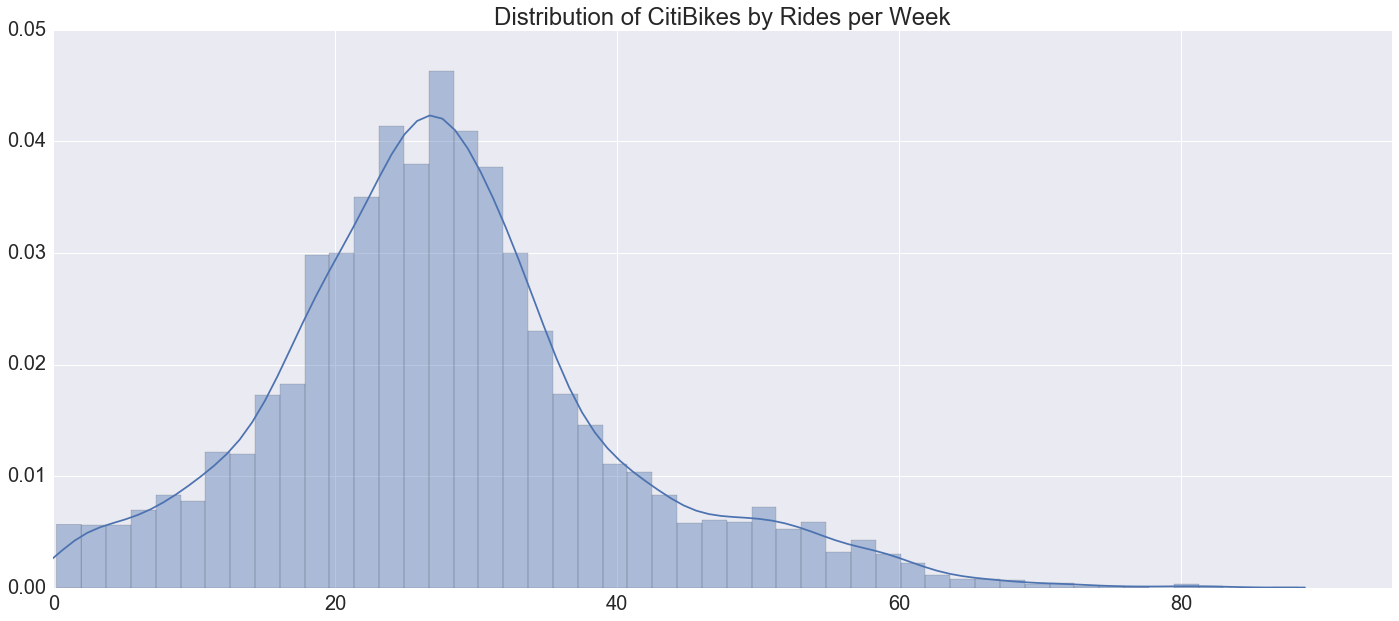

In [9]:
fig = plt.figure(figsize=(24, 10))
sns.set(font_scale=2)
ax = sns.distplot(np.array([len(trip_data[trip_data['bikeid'] == bike]) for bike in trip_data['bikeid'].unique()]) / 31 * 7)
ax.set_xlim([0, 95])
ax.set_title("Distribution of CitiBikes by Rides per Week")

The distribution is mostly normal, as would be expected, with fatter tails on either side. The former tail, near 0, is what is concerning. We want to avoid picking these bikes because they will not be very interesting to visualize!

On the other hand, it would very interesting to watch what some of the bikes on the tail end of this distribution are doing. [If you're curious, IQuantNY has you covered](http://iquantny.tumblr.com/post/86569579414/citi-bike-17279-where-are-you-profiling-the).

In a compromise between realism and visual interest I think that I will pick bikes which are at least in the 50th percentile of activity with respect to their peers. I will put up a percentile marker on the visualization itself to alert viewers as to where the bike they are looking at is with respect to the rest of the bikes in the system.

In [10]:
bikes_by_ride_count = trip_data['bikeid'].value_counts()
active_bikes = bikes_by_ride_count[bikes_by_ride_count > np.mean(bikes_by_ride_count)]

In [11]:
random_bikes = random.sample(list(active_bikes.index), 10)
sample_trips = pd.DataFrame(columns=trip_data.columns)
for day, bike in zip([6]*7, random_bikes):
    selected_trips = trip_data[trip_data['starttime'] < datetime(2016, 3, day + 7)]
    selected_trips = selected_trips[selected_trips['stoptime'] >= datetime(2016, 3, day)]
    selected_trips = selected_trips[selected_trips['bikeid'] == bike]
    sample_trips = sample_trips.append(selected_trips)

With our sample computed we can proceed to saving our output. Only `sample_trips` is saved&mdash;`trip_data` is a small and easily enough accessible file that there's not much benefit to keeping our own copy of the dataset.

In [12]:
sample_trips.index.name = 'Index'
sample_trips.to_csv("../data/part_1/sample_trips.csv")

The next notebook handles constructing coordinate data and converting the data to the `geojson` format.